# Lineages: Identifying boundaries between generations
Natalia Vélez, September 2020

The goal of this notebook is to identify when one generation ends and the next begins. These analyses will help us define time intervals for different community-level models (e.g., repertoire growth, population growth).

In [1]:
%matplotlib inline

import os,re,glob,scipy,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from os.path import join as opj
from tqdm import notebook

from networkx.drawing.nx_agraph import graphviz_layout

sns.set_style('white')
sns.set_context('talk')

## Pick example families

Load family data:

In [2]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
fam_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,avatar,family
0,3983340,time-1613456734_eve-3983313_name-WINDROW
1,3983333,time-1613456734_eve-3983313_name-WINDROW
2,3983314,time-1613456734_eve-3983313_name-WINDROW
3,3983313,time-1613456734_eve-3983313_name-WINDROW
4,3983076,time-1613449020_eve-3983028_name-LODEN


Load lifelog data:

In [3]:
life_df = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
life_df = pd.merge(life_df, fam_df, on='avatar')
life_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,a12bd25b7ca87b4126ab27e4142ab5136f185e2c,3983348,1613458220,3983322,[-6583 -188],1.613462e+09,[-6592 -192],60.00,oldAge,-6583,-188,-6592.0,-192.0,KANE,S,time-1613301538_eve-3976182_name-SOUL
1,7bd530ec132a3123bbc64f1a7b99a890a78c710f,3983347,1613458114,3983274,[-7544 330],1.613461e+09,[-7548 318],42.14,hunger,-7544,330,-7548.0,318.0,DIA,JAMESON,time-1613444669_eve-3982796_name-JAMESON
2,039241fe1322e3c1877753357f239f0e70218553,3983346,1613458026,3983281,[-7552 341],1.613462e+09,[-7548 320],60.00,oldAge,-7552,341,-7548.0,320.0,JANE,JAMESON,time-1613444669_eve-3982796_name-JAMESON
3,6b7abc8753b6a431ed0840d88b2c8f103f933639,3983344,1613458002,3983270,[-7695 128],1.613460e+09,[-7677 119],25.22,hunger,-7695,128,-7677.0,119.0,REX,LODEN,time-1613449020_eve-3983028_name-LODEN
4,c0190e141587c8751a311a41df7183a8d1835262,3983343,1613457977,3983276,[-7570 320],1.613462e+09,[-7687 119],60.00,oldAge,-7570,320,-7687.0,119.0,ADELINE,JAMES,time-1613444669_eve-3982795_name-JAMES


Load success df:

In [4]:
success_df = pd.read_csv('outputs/family_fitness.tsv', sep='\t')
success_df = success_df.sort_values(by='longest_path', ascending=False)
success_df = success_df.reset_index(drop=True)
success_df['log_gen'] = np.log10(success_df['longest_path'])

top_families = success_df.head(10)
top_families

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path,log_gen
0,time-1609746195_eve-3833245_name-STALLINS,2820,3327,2823,510,0.846985,0.000039,21788.670588,2817.918092,357,2.552668
1,time-1611138522_eve-3897231_name-LUCKY,2159,2519,2162,363,0.856238,0.000049,17570.661157,2156.862574,330,2.518514
2,time-1611388293_eve-3906808_name-ARTEMENKO,2093,2344,2096,254,0.891915,0.000041,21751.377953,2090.648511,296,2.471292
3,time-1610335007_eve-3864700_name-APRIL,2027,2363,2030,339,0.856902,0.000052,16562.035398,2024.858590,296,2.471292
4,time-1607255144_eve-3661190_name-RED,2730,3261,2733,534,0.836547,0.000042,19993.550562,2727.980716,292,2.465383
5,time-1584155688_eve-2783193_name-JESUS,1678,2116,1681,441,0.792177,0.000078,10215.433107,1676.246937,238,2.376577
6,time-1582959703_eve-2742223_name-BELLUE,1362,1762,1365,403,0.772059,0.000099,7760.774194,1360.367647,234,2.369216
7,time-1579810712_eve-2612994_name-BOOTS,2178,2856,2181,681,0.762055,0.000063,12032.167401,2176.427673,234,2.369216
8,time-1612793957_eve-3956867_name-BONER,1482,1684,1485,205,0.878698,0.000063,13940.439024,1479.727811,213,2.328380
9,time-1592901881_eve-3098263_name-BATMAN,1423,1788,1426,368,0.794872,0.000091,8750.625000,1421.230769,205,2.311754


Find quantiles of # generations:

In [5]:
log_q = scipy.stats.mstats.mquantiles(success_df['log_gen'], prob=[0.25, 0.5, 0.75, 1])
gen_q = [np.round(10**q) for q in log_q]
print(log_q)
print(gen_q)

[0.30103    0.69897    1.30103    2.55266822]
[2.0, 5.0, 20.0, 357.0]


Plot quantiles:

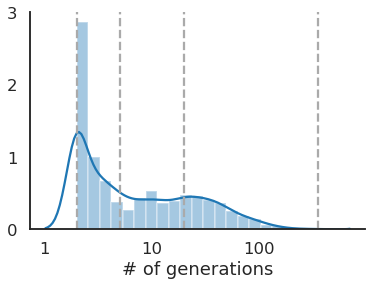

In [6]:
ax = sns.distplot(success_df['log_gen'])
ax.set(xticks = range(3), xticklabels = [10**x for x in range(3)],
       xlabel = '# of generations')

for q in log_q:
    plt.axvline(q, color='#aaaaaa', linestyle='--')
    
sns.despine()

Pick some middling families:

In [7]:
middle_families = success_df[(success_df['longest_path'] >= gen_q[1]) & (success_df['longest_path'] <= gen_q[2])]
print(middle_families.shape)

middle_sample = middle_families.head(10)
middle_sample

(1686, 11)


,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path,log_gen
1467,time-1585442933_eve-2832541_name-NEW,66,117,69,54,0.560976,0.001986,282.444444,65.634146,20,1.30103
1468,time-1575049961_eve-2348886_name-NEW,105,136,108,34,0.760563,0.001273,597.235294,103.436620,20,1.30103
1469,time-1576871159_eve-2440687_name-DOBBIE,89,138,92,52,0.638889,0.001591,401.538462,88.166667,20,1.30103
1470,time-1591982948_eve-3070377_name-BLACK,116,162,119,49,0.708333,0.001222,579.428571,114.750000,20,1.30103
1471,time-1588021559_eve-2942935_name-EGLE,91,148,94,60,0.610390,0.001534,397.833333,90.337662,20,1.30103
1472,time-1587868308_eve-2936998_name-TINI,75,123,78,51,0.604651,0.001839,328.823529,74.372093,20,1.30103
1473,time-1585734183_eve-2844813_name-CORONADO,85,119,88,37,0.704000,0.001654,425.675676,83.776000,20,1.30103
1474,time-1573344803_eve-2256699_name-LEAVY,54,88,57,37,0.606383,0.002512,241.351351,53.361702,20,1.30103
1475,time-1574449213_eve-2316515_name-END,130,200,133,73,0.645631,0.001105,584.136986,129.126214,20,1.30103
1476,time-1591653006_eve-3059891_name-EDRALIN,81,96,84,18,0.823529,0.001411,583.666667,79.058824,20,1.30103


Now we have the families that we're going to use as an example!

In [8]:
sample_families = middle_sample['family'].to_list()
print(*sample_families, sep='\n')

time-1585442933_eve-2832541_name-NEW
time-1575049961_eve-2348886_name-NEW
time-1576871159_eve-2440687_name-DOBBIE
time-1591982948_eve-3070377_name-BLACK
time-1588021559_eve-2942935_name-EGLE
time-1587868308_eve-2936998_name-TINI
time-1585734183_eve-2844813_name-CORONADO
time-1573344803_eve-2256699_name-LEAVY
time-1574449213_eve-2316515_name-END
time-1591653006_eve-3059891_name-EDRALIN


Lifelog data from sample families:

In [9]:
sample_lifelogs = life_df[life_df['family'].isin(sample_families)]
sample_lifelogs = sample_lifelogs.reset_index(drop=True)
print(sample_lifelogs.shape)
sample_lifelogs.head()

(1431, 16)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,11f9fce50bbc1ebbba5126434aea123e79249942,3071475,1592012710,3071436,[-101912 -113],1.592013e+09,[-101922 -126],2.99,hunger,-101912,-113,-101922.0,-126.0,SHELLY,BLACK,time-1591982948_eve-3070377_name-BLACK
1,68c8ef53cc18152d057b93437957bd8f716f65b8,3071448,1592011993,3071397,[-101921 -120],1.592013e+09,[-101925 -126],17.40,murdered,-101921,-120,-101925.0,-126.0,ANN,BLACK,time-1591982948_eve-3070377_name-BLACK
2,bae947e70b2ae2b5f095ab1ce015cccbd9400470,3071438,1592011803,3071397,[-101924 -123],1.592013e+09,[-101988 -136],23.31,hunger,-101924,-123,-101988.0,-136.0,FATE,BLACK,time-1591982948_eve-3070377_name-BLACK
3,2e777fbf90c47f087867842496c86015c1e05316,3071436,1592011777,3071397,[-101928 -105],1.592013e+09,[-101923 -127],19.54,murdered,-101928,-105,-101923.0,-127.0,MCRAE,BLACK,time-1591982948_eve-3070377_name-BLACK
4,8e40f8e1a7dc596d6cbe8d2d1b01407121c36cb5,3071397,1592009825,3071354,[-101926 -121],1.592012e+09,[-101913 -106],40.84,hunger,-101926,-121,-101913.0,-106.0,JOSET,BLACK,time-1591982948_eve-3070377_name-BLACK


Total family durations:

In [10]:
sample_duration = sample_lifelogs.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
sample_duration = sample_duration.rename(columns={'tBirth': 'start', 'tDeath': 'end'})
sample_duration['dur_secs'] = sample_duration['end'] - sample_duration['start']
sample_duration['dur_hours'] = sample_duration['dur_secs']/60/60
sample_duration.head()

,family,start,end,dur_secs,dur_hours
0,time-1573344803_eve-2256699_name-LEAVY,1573344803,1.573378e+09,33642.0,9.345000
1,time-1574449213_eve-2316515_name-END,1574449213,1.574477e+09,27976.0,7.771111
2,time-1575049961_eve-2348886_name-NEW,1575049961,1.575080e+09,30282.0,8.411667
3,time-1576871159_eve-2440687_name-DOBBIE,1576871159,1.576904e+09,32429.0,9.008056
4,time-1585442933_eve-2832541_name-NEW,1585442933,1.585473e+09,30543.0,8.484167


Duration: 7.77-10.04 hours (mean: 8.72)


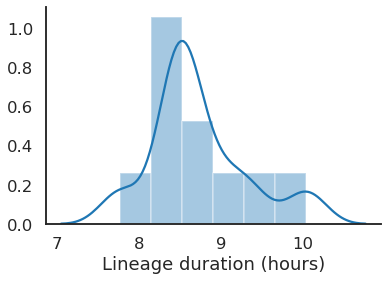

In [11]:
ax = sns.distplot(sample_duration['dur_hours'])
ax.set(xlabel = 'Lineage duration (hours)')
sns.despine()

print('Duration: %0.2f-%0.2f hours (mean: %0.2f)' % (np.min(sample_duration['dur_hours']),
                                                     np.max(sample_duration['dur_hours']),
                                                     np.mean(sample_duration['dur_hours'])))

## Load family data

Helper functions:

In [12]:
def gsearch(*args): return glob.glob(opj(*args))
def str_extract(pattern, s): return re.search(pattern, s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))

def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)


Color-code families:

['#471365', '#482475', '#463480', '#414487', '#3b528b', '#355f8d', '#2f6c8e', '#2a788e', '#25848e', '#21918c', '#1e9c89', '#22a884', '#2fb47c', '#44bf70', '#5ec962', '#7ad151', '#9bd93c', '#bddf26', '#dfe318']


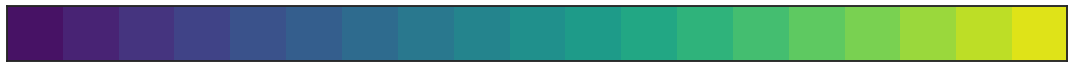

Assign a generation # to each member of the sample families:

In [14]:
plot_kw = 'LOVE'
fam_template = 'outputs/families/families_%s.json'
generations_list = []

for fam in sample_families:
    # Load family tree
    fam_file = fam_template % fam
    fam_graph = open_graph(fam_file)

    # Compute distance from Eve to each relative
    eve = int_extract('(?<=eve-)([0-9]+)', fam_file)
    dist_dict = nx.single_source_shortest_path(fam_graph, eve)
    dist_list = [(fam, k, len(v)-1) for k,v in dist_dict.items()]
    dist_df = pd.DataFrame(dist_list, columns=['family', 'avatar', 'gen'])
    
    # Choose one of the sample families to plot
    if plot_kw in fam:
        # Plot layout
        nx.nx_agraph.write_dot(fam_graph,'fam.dot')
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150
        
        # Draw plot
        plt.subplots(figsize=(w,h))
        fam_color = [gen_hex[len(dist_dict[int(n)])-1] for n in fam_graph.nodes]
        nx.draw(fam_graph, pos, with_labels=False, arrows=True, node_color=fam_color)
    
    generations_list.append(dist_df)

Save to dataframe:

In [15]:
generations = pd.concat(generations_list)
print(generations.shape)
generations.head()

(1431, 3)


,family,avatar,gen
0,time-1585442933_eve-2832541_name-NEW,2832541,0
1,time-1585442933_eve-2832541_name-NEW,2832968,1
2,time-1585442933_eve-2832541_name-NEW,2832947,1
3,time-1585442933_eve-2832541_name-NEW,2832902,1
4,time-1585442933_eve-2832541_name-NEW,2832893,1


## Plot start of each generation

Prepare dataframe of births:

In [16]:
# Get births
births_df = sample_lifelogs[['family', 'avatar', 'tBirth']]
births_df = births_df.sort_values(['family', 'tBirth'])
births_df = births_df.reset_index(drop=True)

# Timelock to Eve's birth
births_df['tEve'] =  births_df.groupby('family')['tBirth'].transform('first') 
births_df['t'] = births_df['tBirth'] - births_df['tEve']

# Assign number to each family
births_df['family_idx'] = births_df['family'].astype('category').cat.codes
births_df['family_name'] = births_df['family'].str.extract('(?<=name-)([A-Z]+)')

# Family groups
fam_list = list(births_df.groupby(['family_idx', 'family_name']).groups)
fam_idx, fam_names = zip(*fam_list)

births_df = pd.merge(births_df, generations, on=['family', 'avatar'])
births_df.head(10)

,family,avatar,tBirth,tEve,t,family_idx,family_name,gen
0,time-1573344803_eve-2256699_name-LEAVY,2256699,1573344803,1573344803,0,0,LEAVY,0
1,time-1573344803_eve-2256699_name-LEAVY,2256700,1573344821,1573344803,18,0,LEAVY,1
2,time-1573344803_eve-2256699_name-LEAVY,2256717,1573345084,1573344803,281,0,LEAVY,1
3,time-1573344803_eve-2256699_name-LEAVY,2256726,1573345383,1573344803,580,0,LEAVY,1
4,time-1573344803_eve-2256699_name-LEAVY,2256730,1573345478,1573344803,675,0,LEAVY,1
5,time-1573344803_eve-2256699_name-LEAVY,2256734,1573345610,1573344803,807,0,LEAVY,1
6,time-1573344803_eve-2256699_name-LEAVY,2256755,1573345914,1573344803,1111,0,LEAVY,1
7,time-1573344803_eve-2256699_name-LEAVY,2256770,1573346118,1573344803,1315,0,LEAVY,1
8,time-1573344803_eve-2256699_name-LEAVY,2256786,1573346334,1573344803,1531,0,LEAVY,1
9,time-1573344803_eve-2256699_name-LEAVY,2256804,1573346773,1573344803,1970,0,LEAVY,2


Generations plot:

In [19]:
gen_hex

['#471365',
 '#482475',
 '#463480',
 '#414487',
 '#3b528b',
 '#355f8d',
 '#2f6c8e',
 '#2a788e',
 '#25848e',
 '#21918c',
 '#1e9c89',
 '#22a884',
 '#2fb47c',
 '#44bf70',
 '#5ec962',
 '#7ad151',
 '#9bd93c',
 '#bddf26',
 '#dfe318']

In [22]:
[len(l) for l in raster_data]

[98, 210, 152, 150, 122, 126, 130, 159, 104, 180]

In [ ]:
raster_colors.head()

In [17]:
# Birth times
raster_data = births_df[['family_idx', 't']]
raster_data = raster_data.groupby('family_idx')['t'].apply(list).to_list()

# Generation colors
raster_colors =  births_df[['family_idx', 'gen']]
raster_colors = raster_colors.groupby('family_idx')['gen'].apply(list).to_list()
raster_colors = [[gen_hex[e] for e in l] for l in raster_colors]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.eventplot(raster_data, linelengths = 0.75, colors = raster_colors)

# Aesthetics
xt = np.linspace(0,600,11)

ax.set(xlabel = 'Time (minutes)',
       xticks = xt*60,
       xticklabels = xt.astype(int),
       yticks = fam_idx,
       yticklabels = fam_names)

IndexError: list index out of range

## Scale to all families

Get all family files:

In [ ]:
all_families = success_df['family'].values
all_gen_list = []

for fam in notebook.tqdm(all_families):
    # Load family tree
    fam_file = fam_template % fam
    fam_graph = open_graph(fam_file)

    # Compute distance from Eve to each relative
    eve = int_extract('(?<=eve-)([0-9]+)', fam_file)
    dist_dict = nx.single_source_shortest_path(fam_graph, eve)
    dist_list = [(fam, k, len(v)-1) for k,v in dist_dict.items()]
    dist_df = pd.DataFrame(dist_list, columns=['family', 'avatar', 'gen'])
    
    all_gen_list.append(dist_df)

Save to dataframe:

In [ ]:
all_generations = pd.concat(all_gen_list)
all_generations.to_csv('outputs/family_generations.tsv', sep='\t', index=False)

print(all_generations.shape)
all_generations.head()

Intervals between generations:

In [ ]:
gen_intervals = pd.merge(life_df, all_generations, on=['family', 'avatar'])

gen_intervals = gen_intervals.groupby(['family', 'gen'])['tBirth'].agg('min').reset_index()
gen_intervals['last_gen'] = gen_intervals.groupby('family')['tBirth'].shift(1)
gen_intervals['lag_min'] = (gen_intervals['tBirth'] - gen_intervals['last_gen'])/60

gen_intervals = gen_intervals.dropna()
gen_intervals = gen_intervals[gen_intervals['lag_min'] < 60]
gen_intervals['last_gen'] = gen_intervals['last_gen'].astype(int)

print(gen_intervals.shape)
gen_intervals.head()

In [ ]:
med_lag =  np.median(gen_intervals['lag_min'])
print('Min: %0.2f' % np.min(gen_intervals['lag_min']))
print('Max: %0.2f' % np.max(gen_intervals['lag_min']))
print('Mean: %0.2f' % np.mean(gen_intervals['lag_min']))
print('Median: %0.2f' % med_lag)

ax = sns.distplot(gen_intervals['lag_min'])
plt.axvline(med_lag, color='#aaaaaa', linestyle='--')
ax.set(xlabel = 'Time between generations')
sns.despine()